# CATBOOST

Objetivo: Entrenar modelo CatBoost con hiperparámetros por defecto para comparar con el baseline (Regresión Logística), XGBoost y LightGBM.

Fases temporales:
- T0 (Matrícula)          : Variables disponibles al momento de inscripción
- T1 (Fin 1er Semestre)   : T0 + variables académicas del 1er semestre, información de matrícula y deudor
- T2 (Fin 2do Semestre)   : T1 + variables académicas del 2do semestre

Preprocesamiento específico para CatBoost:
- No requiere escalado
- Manejo nativo de categóricas (sin Label Encoding)
- Target Encoding para 'course' (alta cardinalidad)

Pipeline:
1. Carga de datos preprocesados
2. Definición de variables por fase temporal
3. Preprocesamiento específico para CatBoost
4. Entrenamiento con Cross-Validation 5-fold
5. Comparación de resultados por fase

## 0. Librerias y configuración

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder

# Modelo
from catboost import CatBoostClassifier
import catboost

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)

# Target Encoding
from category_encoders import TargetEncoder

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directorio de salida
OUTPUT_DIR = "../outputs/figures/modelado/CatBoost/"
OUTPUT_DIR_REPORTES = "../outputs/models/CatBoost/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_REPORTES, exist_ok=True)

# mlflow
import mlflow
import mlflow.sklearn

## 1. Carga de datos preprocesados

In [22]:
# Cargar dataset preprocesado
df = pd.read_csv('../data/processed/preprocessed_data.csv')

print(f"Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas")
print(df['target_binario'].value_counts())
print(f"\nRatio de desbalance: {df['target_binario'].value_counts()[0] / df['target_binario'].value_counts()[1]:.2f}:1")

df.head()

Dataset cargado: 4424 filas x 36 columnas
target_binario
0    3003
1    1421
Name: count, dtype: int64

Ratio de desbalance: 2.11:1


,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,target_binario
0,5,171,1,122.0000,127.3000,1,0,0,1,1,0,20,0,0,0,0,0,0.0000,0,0,0,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,1
1,1,9254,1,160.0000,142.5000,1,0,0,0,1,0,19,0,0,6,6,6,14.0000,0,0,6,6,6,13.6667,0,13.9000,-0.3000,0.7900,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0
2,5,9070,1,122.0000,124.8000,1,0,0,0,1,0,19,0,0,6,0,0,0.0000,0,0,6,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1
3,2,9773,1,122.0000,119.6000,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4000,0,9.4000,-0.8000,-3.1200,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0
4,1,8014,0,100.0000,141.5000,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0000,0,13.9000,-0.3000,0.7900,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0


## 2. Definición de variables por fase temporal (T0, T1, T2)

In [23]:
# TARGET
TARGET = 'target_binario'

# -----------------------------------------------------------------------------
# VARIABLES BINARIAS (no requieren encoding, ya son 0/1)
# -----------------------------------------------------------------------------
VARS_BINARIAS_T0 = [
    'daytimeevening_attendance',
    'displaced',
    'educational_special_needs',
    'gender',
    'scholarship_holder',
    'international',
    'is_single'
]

VARS_BINARIAS_T1 = [
    'debtor',
    'tuition_fees_up_to_date'
]

# -----------------------------------------------------------------------------
# VARIABLES NUMÉRICAS (NO requieren escalado para CatBoost)
# -----------------------------------------------------------------------------
VARS_NUMERICAS_T0 = [
    'age_at_enrollment',
    'admission_grade',
    'previous_qualification_grade'
]

VARS_NUMERICAS_T1 = [
    'curricular_units_1st_sem_credited',
    'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations',
    'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade',
    'curricular_units_1st_sem_without_evaluations',
    'unemployment_rate',
    'inflation_rate',
    'gdp'
]

VARS_NUMERICAS_T2 = [
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade',
    'curricular_units_2nd_sem_without_evaluations'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS AGRUPADAS (CatBoost las maneja nativamente)
# -----------------------------------------------------------------------------
VARS_CATEGORICAS_AGRUPADAS_T0 = [
    'application_mode_risk',
    'previous_qualification_risk',
    'mothers_qualification_level',
    'fathers_qualification_level',
    'mothers_occupation_level',
    'fathers_occupation_level'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS PARA TARGET ENCODING (alta cardinalidad)
# -----------------------------------------------------------------------------
VARS_TARGET_ENCODING_T0 = ['course']

# -----------------------------------------------------------------------------
# VARIABLE ORDINAL (se trata como numérica)
# -----------------------------------------------------------------------------
VARS_ORDINALES_T0 = ['application_order']

# =============================================================================
# COMPOSICIÓN DE VARIABLES POR FASE TEMPORAL
# =============================================================================

# T0: Variables disponibles al momento de matrícula
VARS_T0 = (
    VARS_BINARIAS_T0 +
    VARS_NUMERICAS_T0 +
    VARS_CATEGORICAS_AGRUPADAS_T0 +
    VARS_TARGET_ENCODING_T0 +
    VARS_ORDINALES_T0
)

# T1: T0 + variables del 1er semestre
VARS_T1 = (
    VARS_T0 +
    VARS_BINARIAS_T1 +
    VARS_NUMERICAS_T1
)

# T2: T1 + variables del 2do semestre
VARS_T2 = (
    VARS_T1 +
    VARS_NUMERICAS_T2
)

print("================================================================================")
print("  VARIABLES POR FASE TEMPORAL")
print("================================================================================")
print(f"\n T0 (Matrícula): {len(VARS_T0)} variables")
print(f" T1 (Fin 1er Sem): {len(VARS_T1)} variables (+{len(VARS_T1) - len(VARS_T0)})")
print(f" T2 (Fin 2do Sem): {len(VARS_T2)} variables (+{len(VARS_T2) - len(VARS_T1)})")

  VARIABLES POR FASE TEMPORAL

 T0 (Matrícula): 18 variables
 T1 (Fin 1er Sem): 29 variables (+11)
 T2 (Fin 2do Sem): 35 variables (+6)


## 3. Preparación de datos

In [24]:
# Split se hace en totalidad del dataste, posteriormente se seleccionan las variables según la fase temporal para entrenemiento y evaluación

X = df[VARS_T2].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)


print("================================================================================")
print("  DATOS PARA ENTRENAMIENTO")
print("================================================================================")
print(f"\nTotal registros: {X.shape[0]}")
print(f"Total variables: {X.shape[1]}")

print(f"\nDistribución del target:")
print(y.value_counts())
print(f"Ratio de desbalance: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

  DATOS PARA ENTRENAMIENTO

Total registros: 4424
Total variables: 35

Distribución del target:
target_binario
0    3003
1    1421
Name: count, dtype: int64
Ratio de desbalance: 2.11:1


## 4. Funciones de preprocesamiento para CATBOOST

In [25]:
def obtiene_variables_por_fase(fase):
    # Retorna las listas de variables según la fase temporal
    if fase == 'T0':
        return {
            'binarias': VARS_BINARIAS_T0,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0,
            'categoricas_nativas': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T0
        }
    elif fase == 'T1':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1,
            'categoricas_nativas': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T1
        }
    elif fase == 'T2':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1 + VARS_NUMERICAS_T2,
            'categoricas_nativas': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T2
        }
    else:
        raise ValueError(f"Fase no válida: {fase}. Usar 'T0', 'T1', o 'T2'")





In [26]:
def preprocesamiento_catboost(X_train, X_test, y_train, fase):
    """
    Preprocesa los datos para CatBoost:
    - NO Label Encoding (CatBoost maneja categóricas nativas)
    - Solo Target Encoding para 'course' (alta cardinalidad)
    - Retorna índices de variables categóricas para CatBoost
    """
    variables_fase = obtiene_variables_por_fase(fase)
    
    # Seleccionar solo las variables de la fase
    X_train_fase = X_train[variables_fase['all']].copy()
    X_test_fase = X_test[variables_fase['all']].copy()
    
    # -------------------------------------------------------------------------
    # 1. TARGET ENCODING para 'course' (alta cardinalidad)
    # -------------------------------------------------------------------------
    te = TargetEncoder(cols=variables_fase['categoricas_te'], smoothing=0.3)
    
    for col in variables_fase['categoricas_te']:
        X_train_fase[col + '_encoded'] = te.fit_transform(X_train_fase[[col]], y_train)[col]
        X_test_fase[col + '_encoded'] = te.transform(X_test_fase[[col]])[col]
        # Eliminar columna original
        X_train_fase = X_train_fase.drop(columns=[col])
        X_test_fase = X_test_fase.drop(columns=[col])
    
    # -------------------------------------------------------------------------
    # 2. Convertir categóricas a string (CatBoost las requiere así)
    # -------------------------------------------------------------------------
    for col in variables_fase['categoricas_nativas']:
        X_train_fase[col] = X_train_fase[col].astype(str)
        X_test_fase[col] = X_test_fase[col].astype(str)
    
    # -------------------------------------------------------------------------
    # 3. Obtener índices de columnas categóricas para CatBoost
    # -------------------------------------------------------------------------
    cat_features_idx = [X_train_fase.columns.get_loc(c) for c in variables_fase['categoricas_nativas']]
    cat_features_names = variables_fase['categoricas_nativas']
    
    # -------------------------------------------------------------------------
    # Guardar información
    # -------------------------------------------------------------------------
    variables = X_train_fase.columns.tolist()
    preprocessors = {
        'target_encoder': te,
        'feature_names': variables,
        'cat_features_idx': cat_features_idx,
        'cat_features_names': cat_features_names
    }
    
    return X_train_fase, X_test_fase, variables, preprocessors

## 5. Funciones entrenamiento

In [ ]:
# Entrenamiento con parámetros por defecto
def entrena_catboost(X_train, y_train, fase, cat_features_idx, cv_folds=5):
    """
    Entrena CatBoost con Cross-Validation.
    """

    mlflow.end_run()

    print("================================================================================")
    print(f"  ENTRENAMIENTO CATBOOST - FASE {fase}")
    print("================================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros: {X_train.shape[0]}")
    print(f"Variables categóricas (nativas): {len(cat_features_idx)}")
    
    # -------------------------------------------------------------------------
    # Calcular class_weights para desbalance
    # -------------------------------------------------------------------------
    n_neg = (y_train == 0).sum()
    n_pos = (y_train == 1).sum()
    scale_pos_weight = n_neg / n_pos
    class_weights = {0: 1.0, 1: scale_pos_weight}
    print(f"\nclass_weights: {{0: 1.0, 1: {scale_pos_weight:.2f}}}")
    
    print(f"\nHiperparámetros (por defecto):")
    print(f"   • iterations: 1000")
    print(f"   • depth: 6")
    print(f"   • learning_rate: 0.1")
    print(f"   • l2_leaf_reg: 3")
    
    # -------------------------------------------------------------------------
    # Cross-Validation
    # -------------------------------------------------------------------------
    print(f"\nCross-Validation ({cv_folds}-fold):")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }
    
    train_losses = []
    val_losses = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Crear modelo
        modelo_catb = CatBoostClassifier(
            iterations=1000, 
            depth=6, 
            learning_rate=0.1, 
            l2_leaf_reg=3,
            border_count=254, 
            class_weights=class_weights,
            loss_function='Logloss', 
            eval_metric='F1',
            cat_features=cat_features_idx, 
            random_seed=RANDOM_STATE, 
            verbose=False
        )
        modelo_catb.fit(
            X_fold_train,
            y_fold_train,
            eval_set= (X_fold_train, y_fold_train)
        )

        # Obtener historial de métricas
        train_loss = modelo_catb.get_evals_result()['learn']['Logloss']
        val_loss = modelo_catb.get_evals_result()['validation']['Logloss']
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Predicciones
        y_train_pred = modelo_catb.predict(X_fold_train)
        y_train_proba = modelo_catb.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_catb.predict(X_fold_val)
        y_val_proba = modelo_catb.predict_proba(X_fold_val)[:, 1]
        
        # Métricas Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Métricas Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
    
 
    # Calcular longitud mínima
    min_len = min(len(l) for l in train_losses)
    
    # Recortar y promediar
    train_losses_array = np.array([l[:min_len] for l in train_losses])
    val_losses_array = np.array([l[:min_len] for l in val_losses])
    
    train_mean = train_losses_array.mean(axis=0)
    train_std = train_losses_array.std(axis=0)
    val_mean = val_losses_array.mean(axis=0)
    val_std = val_losses_array.std(axis=0)
    
    iterations = range(1, min_len + 1)
    
    # =========================================================================
    # GRAFICAR
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(iterations, train_mean, label='Train Loss', color='#3498DB', linewidth=2)
    ax.fill_between(iterations, train_mean - train_std, train_mean + train_std, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(iterations, val_mean, label='Validation Loss', color='#E74C3C', linewidth=2)
    ax.fill_between(iterations, val_mean - val_std, val_mean + val_std, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xlabel('Iterations (n_estimators)', fontsize=12)
    ax.set_ylabel('Binary Logloss', fontsize=12)
    ax.set_title(f'Curva de Aprendizaje - CatBoost {fase}\n(Media ± Std de {cv_folds}-Fold CV) Sin Optimizar', fontsize=14)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar punto de mejor validación
    best_iter = np.argmin(val_mean)
    ax.axvline(x=best_iter, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_iter], [val_mean[best_iter]], color='green', s=100, zorder=5,
               label=f'Mejor iteración: {best_iter}')
    ax.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_aprendizaje_catboost_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap
    gap_final = train_mean[-1] - val_mean[-1]
    
    print(f"\n Resumen:")
    print(f"   Mejor iteración: {best_iter}")
    print(f"   Train Loss final: {train_mean[-1]:.4f}")
    print(f"   Val Loss final: {val_mean[-1]:.4f}")
    print(f"   Val Loss mínimo: {val_mean[best_iter]:.4f}")
    print(f"   Gap (Train - Val): {gap_final:.4f}")

    # Convertir a numpy arrays
    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # -------------------------------------------------------------------------
    # Resultados por fold
    # -------------------------------------------------------------------------
    print("\n Resultados por fold:")
    for i in range(cv_folds):
        print(f"\n  Fold {i+1}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_score = cv_results[f'train_{metric}'][i]
            val_score = cv_results[f'test_{metric}'][i]
            print(f"    {metric:<10} | Train: {train_score:.4f} | Val: {val_score:.4f}")


    mlflow.set_experiment("TFM_Dropout_Prediction")
    with mlflow.start_run(run_name=f"CatBoost_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Params por default')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(modelo_catb.get_params())

        # -------------------------------------------------------------------------
        # Resumen CV
        # -------------------------------------------------------------------------
        print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>12} {'Val Mean':>12} {'Val Std':>12}")
        print(f"   {'-'*60}")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_mean = cv_results[f'train_{metric}'].mean()
            train_std = cv_results[f'train_{metric}'].std()
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
            print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>12.4f} {val_mean:>12.4f} {val_std:>12.4f}")
        
        return {
            'phase': fase,
            'n_features': X.shape[1],
            'cv_results': cv_results
        }


def resumen_cv(cv_results, fase, modelo):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    summary = {'modelo': modelo, 'fase': fase}
    
    # -------------------------
    # Métricas de VALIDACIÓN
    # -------------------------
    for metric in metrics:
        summary[f'{metric}_val_mean'] = cv_results[f'test_{metric}'].mean()
        summary[f'{metric}_val_std']  = cv_results[f'test_{metric}'].std()
        

    # -------------------------
    # Métricas de TRAIN
    # -------------------------
    for metric in metrics:
        summary[f'{metric}_train_mean'] = cv_results[f'train_{metric}'].mean()
        summary[f'{metric}_train_std']  = cv_results[f'train_{metric}'].std()

    
    return pd.DataFrame([summary])

In [ ]:
# Optimización con optuna
import optuna

def entrena_catBoost_con_optuna(X_train, y_train, fase, cat_features_idx, n_trials=25, cv_folds=5):
    """
    Entrena LigthGBM con optimización Optuna.
    Optimiza F1-score de clase Dropout (1) 
    """
   
    print("==========================================================================")
    print(f"  OPTIMIZACIÓN CATBOOST CON OPTUNA - FASE {fase}")
    print("==========================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros en train: {X_train.shape[0]}")
    print(f"Trials Optuna: {n_trials}")
    print(f"Variables categóricas (nativas): {len(cat_features_idx)}")
    print(f"Métrica a optimizar: F1-score (clase Dropout)")
    
    # -------------------------------------------------------------------------
    # Calcular class_weights para desbalance
    # -------------------------------------------------------------------------
    n_neg = (y_train == 0).sum()
    n_pos = (y_train == 1).sum()
    scale_pos_weight = n_neg / n_pos
    class_weights = {0: 1.0, 1: scale_pos_weight}
    print(f"\nclass_weights: {{0: 1.0, 1: {scale_pos_weight:.2f}}}")
    

    # =========================================================================
    # FUNCIÓN OBJETIVO PARA OPTUNA
    # =========================================================================
    def objective(trial):
        
        # Hiperparámetros a optimizar
        params = {
            "iterations": trial.suggest_int("iterations", 200, 1200), 
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "depth": trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
            "border_count": trial.suggest_int("border_count", 128, 254),
			"bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
            "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["Balanced", "SqrtBalanced", None]),
            "cat_features": cat_features_idx,
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "random_seed": RANDOM_STATE,
            "verbose": False,
            "early_stopping_rounds": 50  # ← Detiene si no mejora en 50 iteraciones
        }

        # -------------------------------------------------------------------------
        # Cross-Validation
        # -------------------------------------------------------------------------
        #print(f"\nCross-Validation ({cv_folds}-fold)-:")

        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
        scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_fold_train = X_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_val = y_train.iloc[val_idx]
            
            try:
                modelo_catb_opt_cv = CatBoostClassifier(**params) 
                modelo_catb_opt_cv.fit(
                    X_fold_train, y_fold_train,
                    eval_set=(X_fold_val, y_fold_val),  # ← Necesario para early_stopping
                    verbose=False
                )


                y_pred = modelo_catb_opt_cv.predict(X_fold_val)
                
                # F1-score de clase 1 (Dropout)
                f1 = f1_score(y_fold_val, y_pred, pos_label=1)
                scores.append(f1)
                
            except Exception:
                return 0.0
        
        return np.mean(scores)


    # =========================================================================
    # EJECUTAR OPTIMIZACIÓN
    # =========================================================================
    print(f"\nProceso de optimización")
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'F1-socre_{fase}',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    # =========================================================================
    # MEJORES HIPERPARÁMETROS
    # =========================================================================
    best_params = study.best_params
    best_f1_score = study.best_value
    
    
    print(f"\n{'='*70}")
    print(f"  MEJORES HIPERPARÁMETROS")
    print(f"{'='*70}")
    print(f"  Mejor F1-score (CV): {best_f1_score:.4f}")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # =========================================================================
    # EVALUACIÓN FINAL CON MEJORES PARAMS
    # =========================================================================
    final_params = {
        'iterations': best_params['iterations'],
        'learning_rate': best_params['learning_rate'],
        'depth': best_params['depth'],
        'l2_leaf_reg': best_params['l2_leaf_reg'],
        'border_count': best_params['border_count'],
        'bagging_temperature': best_params['bagging_temperature'],
        'random_strength': best_params['random_strength'],
        'auto_class_weights': best_params['auto_class_weights'],
        'cat_features': cat_features_idx,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'random_seed': RANDOM_STATE,
        'verbose': False,
        "early_stopping_rounds": 50  # ← Detiene si no mejora en 50 iteraciones
    }

    
    # CV final con todas las métricas
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }
    
    train_losses = []
    val_losses = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        modelo_catb_opt = CatBoostClassifier(**final_params)

        modelo_catb_opt.fit(
            X_fold_train,
            y_fold_train,
            eval_set= (X_fold_val, y_fold_val)
        )

        # Obtener historial de métricas
        train_loss = modelo_catb_opt.get_evals_result()['learn']['Logloss']
        val_loss = modelo_catb_opt.get_evals_result()['validation']['Logloss']
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        y_train_pred = modelo_catb_opt.predict(X_fold_train)
        y_train_proba = modelo_catb_opt.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_catb_opt.predict(X_fold_val)
        y_val_proba = modelo_catb_opt.predict_proba(X_fold_val)[:, 1]
        
        # Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
    

    # Calcula longitud mínima
    min_len = min(len(l) for l in train_losses)
    
    # Recortar y promediar
    train_losses_array = np.array([l[:min_len] for l in train_losses])
    val_losses_array = np.array([l[:min_len] for l in val_losses])
    
    train_mean = train_losses_array.mean(axis=0)
    train_std = train_losses_array.std(axis=0)
    val_mean = val_losses_array.mean(axis=0)
    val_std = val_losses_array.std(axis=0)
    
    iterations = range(1, min_len + 1)
    
    # =========================================================================
    # GRAFICA
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(iterations, train_mean, label='Train Loss', color='#3498DB', linewidth=2)
    ax.fill_between(iterations, train_mean - train_std, train_mean + train_std, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(iterations, val_mean, label='Validation Loss', color='#E74C3C', linewidth=2)
    ax.fill_between(iterations, val_mean - val_std, val_mean + val_std, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xlabel('Iterations (n_estimators)', fontsize=12)
    ax.set_ylabel('Binary Logloss', fontsize=12)
    ax.set_title(f'Curva de Aprendizaje - CatBoost {fase}\n(Media ± Std de {cv_folds}-Fold CV) - Optimizado', fontsize=14)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar punto de mejor validación
    best_iter = np.argmin(val_mean)
    ax.axvline(x=best_iter, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_iter], [val_mean[best_iter]], color='green', s=100, zorder=5,
               label=f'Mejor iteración: {best_iter}')
    ax.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_aprendizaje_catboost_opt_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap
    gap_final = train_mean[-1] - val_mean[-1]
    
    print(f"\n Resumen:")
    print(f"   Mejor iteración: {best_iter}")
    print(f"   Train Loss final: {train_mean[-1]:.4f}")
    print(f"   Val Loss final: {val_mean[-1]:.4f}")
    print(f"   Val Loss mínimo: {val_mean[best_iter]:.4f}")
    print(f"   Gap (Train - Val): {gap_final:.4f}")

    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # =========================================================================
    # RESUMEN CV
    # =========================================================================
    print(f"\n{'='*70}")
    print(f"  RESUMEN CROSS-VALIDATION (Optimizado)")
    print(f"{'='*70}")
    print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>10} {'Val Mean':>12} {'Val Std':>10}")
    print(f"   {'-'*60}")
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        val_mean = cv_results[f'test_{metric}'].mean()
        val_std = cv_results[f'test_{metric}'].std()
        marker = "****" if metric == 'f1' else ""

        print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>10.4f} {val_mean:>12.4f} {val_std:>10.4f}{marker}")


    with mlflow.start_run(run_name=f"OptunaCoste_CatBoost_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Baseline - Optimizado_Optuna')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(modelo_catb_opt.get_params())
        mlflow.log_param("n_trials", n_trials)
        mlflow.log_param("cv_folds", cv_folds)
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_metric("optuna_best_f1_cv", best_f1_score)
    
    
    # =========================================================================
    # MODELO FINAL PARA Entrenamiento previo a la evaluacion
    # =========================================================================
        #model_final_lgb = LGBMClassifier(**final_params)
        #model_final_lgb.fit(X_train, y_train)

        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
        

    # =========================================================================
    # RETORNAR
    # =========================================================================
    results = {
        'fase': fase,
        'model': modelo_catb_opt,
        'best_params': best_params,
        'best_f1_sore_cv': best_f1_score,
        'cv_results': cv_results,
        'study': study,
    }

    return results   
    

## 6. Modelado FASE T0 (MATRÍCULA)

In [30]:
# Preprocesamiento para T0
X_train_T0, X_test_T0, features_T0, prep_T0 = preprocesamiento_catboost(
    X_train, X_test, y_train, fase='T0'
)

print(f"\nT0 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T0.shape}")
print(f"   Test:  {X_test_T0.shape}")
print(f"   Variables: {len(features_T0)}")
print(f"   Variables categóricas (índices): {prep_T0['cat_features_idx']}")
print(f"   Variables categóricas (nombres): {prep_T0['cat_features_names']}")
print(f"   \nLas variables son:")
X_train_T0.columns



T0 - Dimensiones después del preprocesamiento:
   Train: (3539, 18)
   Test:  (885, 18)
   Variables: 18
   Variables categóricas (índices): [10, 11, 12, 13, 14, 15]
   Variables categóricas (nombres): ['application_mode_risk', 'previous_qualification_risk', 'mothers_qualification_level', 'fathers_qualification_level', 'mothers_occupation_level', 'fathers_occupation_level']
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'course_encoded'],
      dtype='object')

### Parámetros por defecto

  ENTRENAMIENTO CATBOOST - FASE T0

Variables: 18
Registros: 3539
Variables categóricas (nativas): 6

class_weights: {0: 1.0, 1: 2.11}

Hiperparámetros (por defecto):
   • iterations: 1000
   • depth: 6
   • learning_rate: 0.1
   • l2_leaf_reg: 3

Cross-Validation (5-fold):


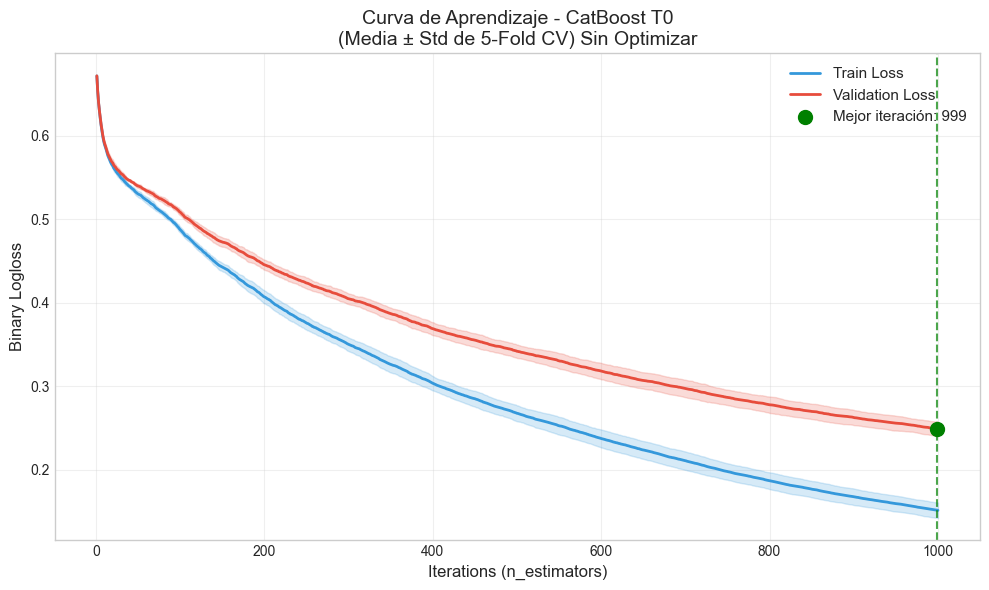


 Resumen:
   Mejor iteración: 999
   Train Loss final: 0.1517
   Val Loss final: 0.2491
   Val Loss mínimo: 0.2491
   Gap (Train - Val): -0.0974

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.9325 | Val: 0.6921
    precision  | Train: 0.8803 | Val: 0.5223
    recall     | Train: 0.9142 | Val: 0.5132
    f1         | Train: 0.8969 | Val: 0.5177
    roc_auc    | Train: 0.9821 | Val: 0.7111

  Fold 2:
    accuracy   | Train: 0.9209 | Val: 0.6992
    precision  | Train: 0.8542 | Val: 0.5362
    recall     | Train: 0.9087 | Val: 0.4868
    f1         | Train: 0.8806 | Val: 0.5103
    roc_auc    | Train: 0.9764 | Val: 0.7327

  Fold 3:
    accuracy   | Train: 0.9350 | Val: 0.6879
    precision  | Train: 0.8682 | Val: 0.5126
    recall     | Train: 0.9407 | Val: 0.5374
    f1         | Train: 0.9030 | Val: 0.5247
    roc_auc    | Train: 0.9844 | Val: 0.7121

  Fold 4:
    accuracy   | Train: 0.9347 | Val: 0.7203
    precision  | Train: 0.8812 | Val: 0.5612
    recall     | Train

In [31]:
# Entrenar y evaluar T0
results_T0 = entrena_catboost(
    X_train_T0, y_train,
    fase='T0', 
    cat_features_idx=prep_T0['cat_features_idx']
)

df_resumen_catBoost = resumen_cv(
    cv_results=results_T0['cv_results'],
    fase='T0',
    modelo='CatBoost'
)
# Guardar tabla de comparación
df_resumen_catBoost.to_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_CatBoost.csv", index=False)

print(f"Resultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_CatBoost.csv")

### Optimización

  OPTIMIZACIÓN CATBOOST CON OPTUNA - FASE T0

Variables: 18
Registros en train: 3539
Trials Optuna: 25
Variables categóricas (nativas): 6
Métrica a optimizar: F1-score (clase Dropout)

class_weights: {0: 1.0, 1: 2.11}

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.6047
    iterations: 219
    learning_rate: 0.29572919322251784
    depth: 7
    l2_leaf_reg: 1.0859325539562723
    border_count: 131
    bagging_temperature: 0.3073686643512338
    random_strength: 9.580055402844472
    auto_class_weights: Balanced
Mejores hiperparámetros encontrados en la fase: {fase}
iterations: 219
learning_rate: 0.29572919322251784
depth: 7
l2_leaf_reg: 1.0859325539562723
border_count: 131
bagging_temperature: 0.3073686643512338
random_strength: 9.580055402844472
auto_class_weights: Balanced


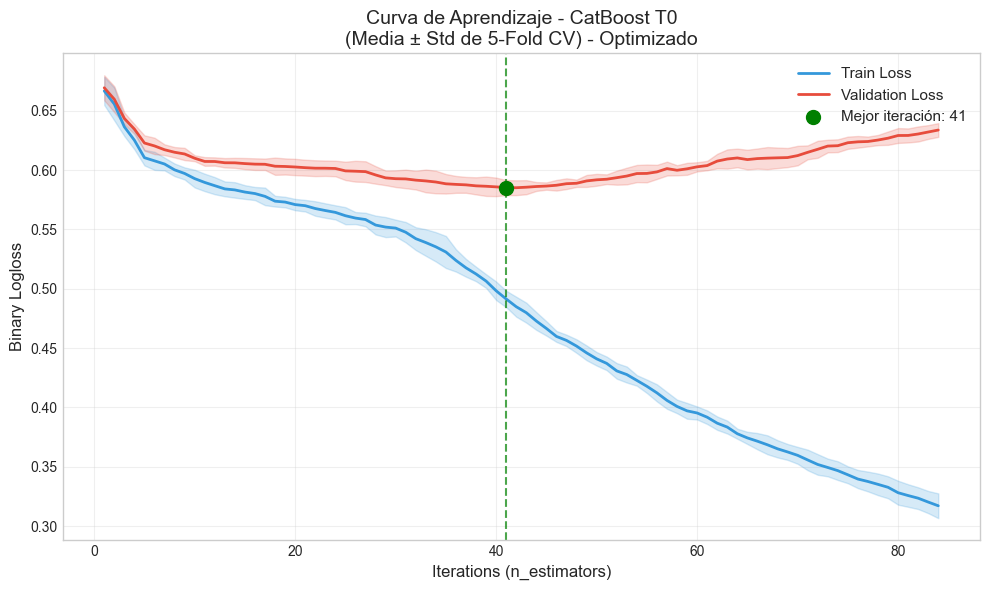


 Resumen:
   Mejor iteración: 41
   Train Loss final: 0.3171
   Val Loss final: 0.6338
   Val Loss mínimo: 0.5852
   Gap (Train - Val): -0.3168

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.7407     0.0207       0.7109     0.0118
   precision          0.5775     0.0280       0.5398     0.0155
   recall             0.7276     0.0170       0.6878     0.0109
   f1                 0.6436     0.0221       0.6047     0.0099****
   roc_auc            0.8174     0.0212       0.7593     0.0044
🏃 View run OptunaCoste_CatBoost_CV5_T0 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/09b8eb02f1da483dafc6db4a1346a9f8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.5305
  Optuna:   0.6047

Resultados guardados en: ../outputs/models/CatBoost/cv_summary_CatBoost.csv


In [32]:
results_T0_optuna = entrena_catBoost_con_optuna(X_train_T0, y_train, fase='T0', cat_features_idx=prep_T0['cat_features_idx'], n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T0['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T0_optuna['best_f1_sore_cv']:.4f}")

df_resumen_catB_T0_opt = resumen_cv(
    cv_results=results_T0_optuna['cv_results'],
    fase='T0',
    modelo='CatBoost_opt'
)

catB_path = "../outputs/models/CatBoost/cv_summary_CatBoost.csv"
df_catB = pd.read_csv(catB_path)
df_final = pd.concat([df_catB, df_resumen_catB_T0_opt], ignore_index=True)
csv_path = "cv_summary_CatBoost.csv"

# Guardar tabla de comparación
df_final.to_csv(catB_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_CatBoost.csv")

## 7. Modelado FASE T1 (FIN 1ER SEMESTRE)

In [33]:
# Preprocesamiento para T1
X_train_T1, X_test_T1, features_T1, prep_T1 = preprocesamiento_catboost(
    X_train, X_test, y_train, fase='T1'
)

print(f"\nT0 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T1.shape}")
print(f"   Test:  {X_test_T1.shape}")
print(f"   Variables: {len(features_T0)}")
print(f"   Variables categóricas (índices): {prep_T1['cat_features_idx']}")
print(f"   Variables categóricas (nombres): {prep_T1['cat_features_names']}")
print(f"   \nLas variables son:")
X_train_T1.columns



T0 - Dimensiones después del preprocesamiento:
   Train: (3539, 29)
   Test:  (885, 29)
   Variables: 18
   Variables categóricas (índices): [10, 11, 12, 13, 14, 15]
   Variables categóricas (nombres): ['application_mode_risk', 'previous_qualification_risk', 'mothers_qualification_level', 'fathers_qualification_level', 'mothers_occupation_level', 'fathers_occupation_level']
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'debtor', 'tuition_fees_up_to_date',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations', 'unemployment_rate',
       'inflation_rate', 'gdp', 'course_encoded'],
      dtype='object')

### Parámetros por defecto

  ENTRENAMIENTO CATBOOST - FASE T1

Variables: 29
Registros: 3539
Variables categóricas (nativas): 6

class_weights: {0: 1.0, 1: 2.11}

Hiperparámetros (por defecto):
   • iterations: 1000
   • depth: 6
   • learning_rate: 0.1
   • l2_leaf_reg: 3

Cross-Validation (5-fold):


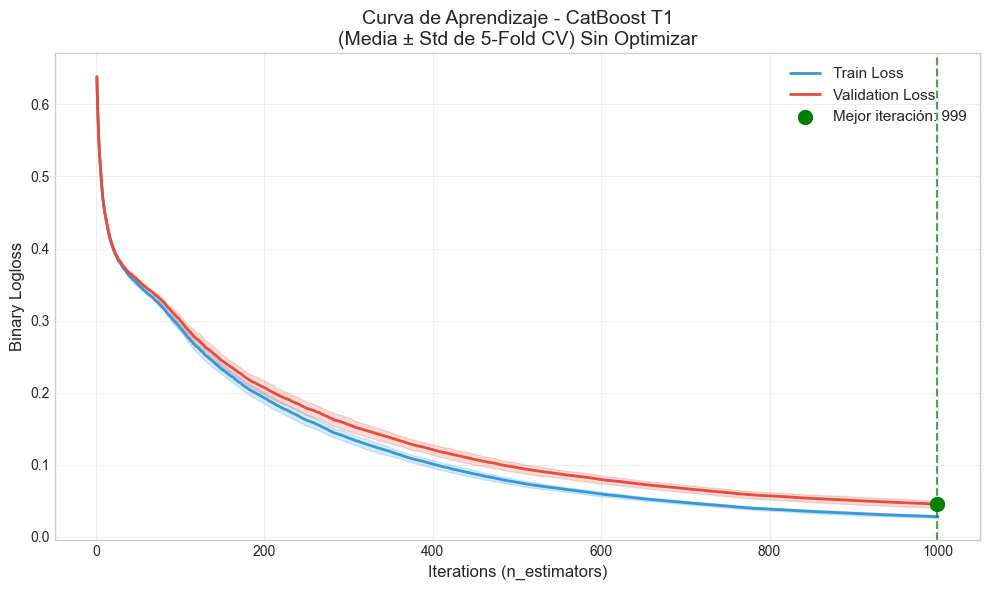


 Resumen:
   Mejor iteración: 999
   Train Loss final: 0.0278
   Val Loss final: 0.0453
   Val Loss mínimo: 0.0453
   Gap (Train - Val): -0.0175

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.9989 | Val: 0.8475
    precision  | Train: 1.0000 | Val: 0.7804
    recall     | Train: 0.9967 | Val: 0.7325
    f1         | Train: 0.9983 | Val: 0.7557
    roc_auc    | Train: 1.0000 | Val: 0.8936

  Fold 2:
    accuracy   | Train: 0.9968 | Val: 0.8460
    precision  | Train: 0.9956 | Val: 0.7990
    recall     | Train: 0.9945 | Val: 0.6974
    f1         | Train: 0.9950 | Val: 0.7447
    roc_auc    | Train: 0.9999 | Val: 0.8842

  Fold 3:
    accuracy   | Train: 0.9979 | Val: 0.8460
    precision  | Train: 0.9978 | Val: 0.7634
    recall     | Train: 0.9956 | Val: 0.7533
    f1         | Train: 0.9967 | Val: 0.7583
    roc_auc    | Train: 1.0000 | Val: 0.9039

  Fold 4:
    accuracy   | Train: 0.9958 | Val: 0.8602
    precision  | Train: 0.9956 | Val: 0.8168
    recall     | Train

In [34]:
# Entrenar y evaluar T1
results_T1 = entrena_catboost(
    X_train_T1, y_train,
    fase='T1', 
    cat_features_idx=prep_T1['cat_features_idx']
)

df_resumen_catBoost = resumen_cv(
    cv_results=results_T1['cv_results'],
    fase='T1',
    modelo='CatBoost'
)

catB_path = "../outputs/models/CatBoost/cv_summary_CatBoost.csv"
df_catB = pd.read_csv(catB_path)
df_final = pd.concat([df_catB, df_resumen_catBoost], ignore_index=True)
csv_path = "cv_summary_CatBoost.csv"

# Guardar tabla de comparación
df_final.to_csv(catB_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_CatBoost.csv")

### Optimización

  OPTIMIZACIÓN CATBOOST CON OPTUNA - FASE T1

Variables: 29
Registros en train: 3539
Trials Optuna: 25
Variables categóricas (nativas): 6
Métrica a optimizar: F1-score (clase Dropout)

class_weights: {0: 1.0, 1: 2.11}

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.7786
    iterations: 724
    learning_rate: 0.17178329359598113
    depth: 4
    l2_leaf_reg: 2.647297025653965
    border_count: 182
    bagging_temperature: 6.338562112382173
    random_strength: 3.3848344546818883
    auto_class_weights: SqrtBalanced
Mejores hiperparámetros encontrados en la fase: {fase}
iterations: 724
learning_rate: 0.17178329359598113
depth: 4
l2_leaf_reg: 2.647297025653965
border_count: 182
bagging_temperature: 6.338562112382173
random_strength: 3.3848344546818883
auto_class_weights: SqrtBalanced


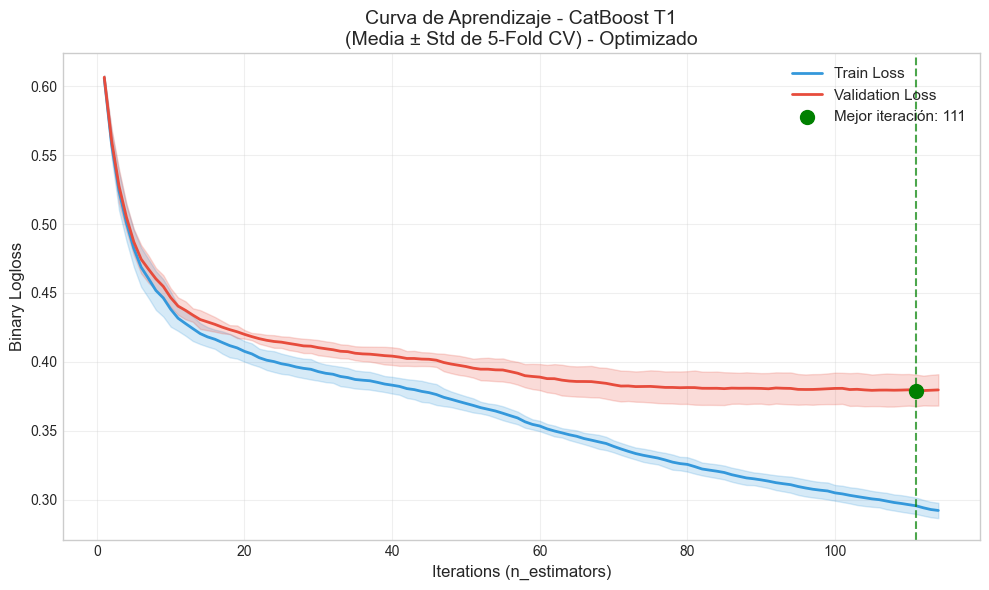


 Resumen:
   Mejor iteración: 111
   Train Loss final: 0.2924
   Val Loss final: 0.3798
   Val Loss mínimo: 0.3793
   Gap (Train - Val): -0.0874

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.8921     0.0184       0.8632     0.0033
   precision          0.8575     0.0254       0.8116     0.0127
   recall             0.7959     0.0364       0.7485     0.0134
   f1                 0.8255     0.0311       0.7786     0.0050****
   roc_auc            0.9403     0.0189       0.8993     0.0106
🏃 View run OptunaCoste_CatBoost_CV5_T1 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/81a25bb0433e4818a375832c2fb902fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.7529
  Optuna:   0.7786

Resultados guardados en: ../outputs/models/CatBoost/cv_summary_CatBoost.csv


In [35]:
results_T1_optuna = entrena_catBoost_con_optuna(X_train_T1, y_train, fase='T1', cat_features_idx=prep_T1['cat_features_idx'], n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T1['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T1_optuna['best_f1_sore_cv']:.4f}")

df_resumen_catB_T1_opt = resumen_cv(
    cv_results=results_T1_optuna['cv_results'],
    fase='T1',
    modelo='CatBoost_opt'
)

catB_path = "../outputs/models/CatBoost/cv_summary_CatBoost.csv"
df_catB = pd.read_csv(catB_path)
df_final = pd.concat([df_catB, df_resumen_catB_T1_opt], ignore_index=True)
csv_path = "cv_summary_CatBoost.csv"

# Guardar tabla de comparación
df_final.to_csv(catB_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_CatBoost.csv")

## 8. Modelado FASE T2 (FIN 2DO SEMESTRE)

In [37]:
# Preprocesamiento para T1
X_train_T2, X_test_T2, features_T2, prep_T2 = preprocesamiento_catboost(
    X_train, X_test, y_train, fase='T2'
)

print(f"\nT0 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T2.shape}")
print(f"   Test:  {X_train_T2.shape}")
print(f"   Variables: {len(features_T2)}")
print(f"   Variables categóricas (índices): {prep_T2['cat_features_idx']}")
print(f"   Variables categóricas (nombres): {prep_T2['cat_features_names']}")
print(f"   \nLas variables son:")
X_train_T2.columns


T0 - Dimensiones después del preprocesamiento:
   Train: (3539, 35)
   Test:  (3539, 35)
   Variables: 35
   Variables categóricas (índices): [10, 11, 12, 13, 14, 15]
   Variables categóricas (nombres): ['application_mode_risk', 'previous_qualification_risk', 'mothers_qualification_level', 'fathers_qualification_level', 'mothers_occupation_level', 'fathers_occupation_level']
   
Las variables son:


Index(['daytimeevening_attendance', 'displaced', 'educational_special_needs',
       'gender', 'scholarship_holder', 'international', 'is_single',
       'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
       'application_mode_risk', 'previous_qualification_risk',
       'mothers_qualification_level', 'fathers_qualification_level',
       'mothers_occupation_level', 'fathers_occupation_level',
       'application_order', 'debtor', 'tuition_fees_up_to_date',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations', 'unemployment_rate',
       'inflation_rate', 'gdp', 'curricular_units_2nd_sem_credited',
       'curricular_units_2nd_sem_enrolled',
       'curricular_units_2nd_sem_evaluations',
       'curricular_units_2nd_sem_approved', 'curricular_units_2nd

### Parámetros por defecto

  ENTRENAMIENTO CATBOOST - FASE T2

Variables: 35
Registros: 3539
Variables categóricas (nativas): 6

class_weights: {0: 1.0, 1: 2.11}

Hiperparámetros (por defecto):
   • iterations: 1000
   • depth: 6
   • learning_rate: 0.1
   • l2_leaf_reg: 3

Cross-Validation (5-fold):


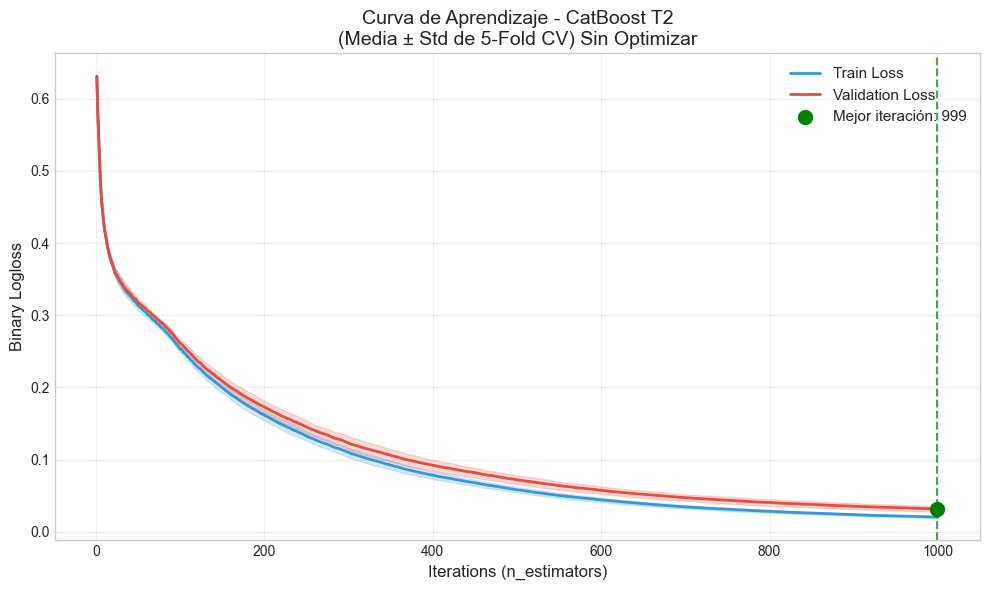


 Resumen:
   Mejor iteración: 999
   Train Loss final: 0.0204
   Val Loss final: 0.0316
   Val Loss mínimo: 0.0316
   Gap (Train - Val): -0.0113

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.9993 | Val: 0.8785
    precision  | Train: 0.9989 | Val: 0.8318
    recall     | Train: 0.9989 | Val: 0.7807
    f1         | Train: 0.9989 | Val: 0.8054
    roc_auc    | Train: 1.0000 | Val: 0.9060

  Fold 2:
    accuracy   | Train: 0.9947 | Val: 0.8559
    precision  | Train: 0.9923 | Val: 0.7972
    recall     | Train: 0.9912 | Val: 0.7412
    f1         | Train: 0.9917 | Val: 0.7682
    roc_auc    | Train: 0.9997 | Val: 0.9124

  Fold 3:
    accuracy   | Train: 0.9986 | Val: 0.8672
    precision  | Train: 0.9967 | Val: 0.8009
    recall     | Train: 0.9989 | Val: 0.7797
    f1         | Train: 0.9978 | Val: 0.7902
    roc_auc    | Train: 1.0000 | Val: 0.9150

  Fold 4:
    accuracy   | Train: 0.9993 | Val: 0.8701
    precision  | Train: 1.0000 | Val: 0.8426
    recall     | Train

In [38]:
# Entrenar y evaluar T2
results_T2 = entrena_catboost(
    X_train_T2, y_train,
    fase='T2', 
    cat_features_idx=prep_T2['cat_features_idx']
)

df_resumen_catBoost = resumen_cv(
    cv_results=results_T2['cv_results'],
    fase='T2',
    modelo='CatBoost'
)

catB_path = "../outputs/models/CatBoost/cv_summary_CatBoost.csv"
df_catB = pd.read_csv(catB_path)
df_final = pd.concat([df_catB, df_resumen_catBoost], ignore_index=True)
csv_path = "cv_summary_CatBoost.csv"

# Guardar tabla de comparación
df_final.to_csv(catB_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_CatBoost.csv")

### Optimización

  OPTIMIZACIÓN CATBOOST CON OPTUNA - FASE T2

Variables: 35
Registros en train: 3539
Trials Optuna: 25
Variables categóricas (nativas): 6
Métrica a optimizar: F1-score (clase Dropout)

class_weights: {0: 1.0, 1: 2.11}

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.8062
    iterations: 925
    learning_rate: 0.10375434829158396
    depth: 6
    l2_leaf_reg: 1.5537542842917214
    border_count: 223
    bagging_temperature: 0.26368084405807757
    random_strength: 6.090738634337445
    auto_class_weights: SqrtBalanced


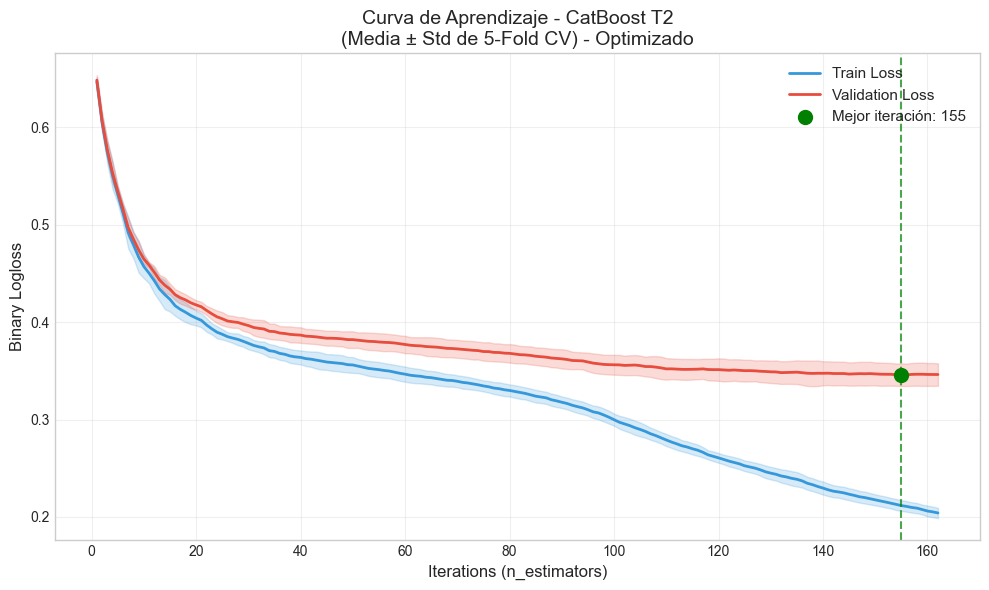


 Resumen:
   Mejor iteración: 155
   Train Loss final: 0.2041
   Val Loss final: 0.3462
   Val Loss mínimo: 0.3459
   Gap (Train - Val): -0.1421

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.9183     0.0121       0.8808     0.0082
   precision          0.8966     0.0145       0.8440     0.0208
   recall             0.8426     0.0261       0.7722     0.0198
   f1                 0.8687     0.0204       0.8062     0.0131****
   roc_auc            0.9649     0.0094       0.9172     0.0082
🏃 View run OptunaCoste_CatBoost_CV5_T2 at: http://127.0.0.1:5000/#/experiments/570026133514462797/runs/5503f2603863400990a20550bec993bc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570026133514462797

Comparación F1-score:
  Baseline: 0.7897
  Optuna:   0.8062

Resultados guardados en: ../outputs/models/CatBoost/cv_summary_CatBoost.csv


In [18]:
results_T2_optuna = entrena_catBoost_con_optuna(X_train_T2, y_train, fase='T2', cat_features_idx=prep_T2['cat_features_idx'], n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T2['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T2_optuna['best_f1_sore_cv']:.4f}")

df_resumen_catB_T2_opt = resumen_cv(
    cv_results=results_T2_optuna['cv_results'],
    fase='T2',
    modelo='CatBoost_opt'
)

catB_path = "../outputs/models/CatBoost/cv_summary_CatBoost.csv"
df_catB = pd.read_csv(catB_path)
df_final = pd.concat([df_catB, df_resumen_catB_T2_opt], ignore_index=True)
csv_path = "cv_summary_CatBoost.csv"

# Guardar tabla de comparación
df_final.to_csv(catB_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_CatBoost.csv")

## 9. Resumen Final

In [19]:
# Mostrar resumen final
df_final = pd.read_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_CatBoost.csv")

print("================================================================================")
print("  RESUMEN CATBOOST - CROSS VALIDATION")
print("================================================================================")
print(df_final.to_string(index=False))

  RESUMEN CATBOOST - CROSS VALIDATION
      modelo fase  accuracy_val_mean  accuracy_val_std  precision_val_mean  precision_val_std  recall_val_mean  recall_val_std  f1_val_mean  f1_val_std  roc_auc_val_mean  roc_auc_val_std  accuracy_train_mean  accuracy_train_std  precision_train_mean  precision_train_std  recall_train_mean  recall_train_std  f1_train_mean  f1_train_std  roc_auc_train_mean  roc_auc_train_std
    CatBoost   T0             0.6993            0.0112              0.5322             0.0164           0.5295          0.0327       0.5305      0.0221            0.7281           0.0149               0.9330              0.0069                0.8802               0.0209             0.9171            0.0135         0.8980        0.0096              0.9813             0.0031
CatBoost_opt   T0             0.7109            0.0118              0.5398             0.0155           0.6878          0.0109       0.6047      0.0099            0.7593           0.0044               0.7407   

## 10. Resumen completo de entrenamiento (Todos los algoritmos)

In [20]:
resumen_path = "../outputs/models/cv_summary_entrenamiento.csv"
df_resumen = pd.read_csv(resumen_path)

cb_path = "../outputs/models/CatBoost/cv_summary_CatBoost.csv"
df_cb = pd.read_csv(cb_path)

df_resumen = pd.concat([df_resumen, df_cb], ignore_index=True)

# Guardar tabla de comparación
df_resumen.to_csv(f"../outputs/models/cv_summary_entrenamiento.csv", index=False)

print(f"Resultados guardados en: ../outputs/models/cv_summary_entrenamiento.csv")

Resultados guardados en: ../outputs/models/cv_summary_entrenamiento.csv
